In [107]:
import json
from tqdm import tqdm
import cv2
import numpy as np

In [108]:
# Patch metadata
row, col = 0, 34
patch_size = 1024
overlap = 0.0625  # 6.25%
step_size = int(patch_size * (1 - overlap))

In [109]:
patch_image_path = f"/media/network/hdd/santosh/cellvit_preprocessing_gall-bladder/patches/S2503154_A8_tiff_pyramid/patches/S2503154_A8_tiff_pyramid_{row}_{col}.png"
patch = cv2.imread(patch_image_path)
print(f"Patch image shape: {patch.shape}")

Patch image shape: (1024, 1024, 3)


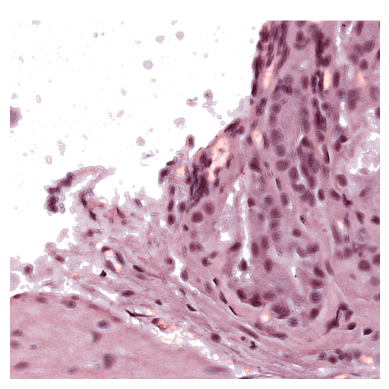

In [110]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [111]:
# Calculate patch offset
x_offset = col * step_size
y_offset = row * step_size
patch_bounds = (x_offset, y_offset, x_offset + patch_size, y_offset + patch_size)
patch_bounds

(32640, 0, 33664, 1024)

In [112]:
geojson_path = "/media/network/hdd/santosh/cellvit_preprocessing_gall-bladder/patches/S2503154_A8_tiff_pyramid/cell_detection/cells.geojson"
with open(geojson_path, "r") as f:
    geojson_data = json.load(f)

In [113]:
def get_centroid(coords):
    coords = np.array(coords)
    x, y = coords[:, 0], coords[:, 1]
    centroid_x = np.mean(x)
    centroid_y = np.mean(y)
    return centroid_x, centroid_y

In [114]:
(
    geojson_data[0].keys(),
    geojson_data[1].keys(),
    geojson_data[2].keys(),
    geojson_data[3].keys(),
    geojson_data[4].keys(),
)

(dict_keys(['type', 'id', 'geometry', 'properties']),
 dict_keys(['type', 'id', 'geometry', 'properties']),
 dict_keys(['type', 'id', 'geometry', 'properties']),
 dict_keys(['type', 'id', 'geometry', 'properties']),
 dict_keys(['type', 'id', 'geometry', 'properties']))

In [115]:
(
    geojson_data[0]['properties'],
    geojson_data[1]['properties'],
    geojson_data[2]['properties'],
    geojson_data[3]['properties'],
    geojson_data[4]['properties'],
)

({'objectType': 'annotation',
  'classification': {'name': 'Neoplastic', 'color': [255, 0, 0]}},
 {'objectType': 'annotation',
  'classification': {'name': 'Inflammatory', 'color': [34, 221, 77]}},
 {'objectType': 'annotation',
  'classification': {'name': 'Connective', 'color': [35, 92, 236]}},
 {'objectType': 'annotation',
  'classification': {'name': 'Dead', 'color': [254, 255, 0]}},
 {'objectType': 'annotation',
  'classification': {'name': 'Epithelial', 'color': [255, 159, 68]}})

In [116]:
(
    geojson_data[0]["geometry"]["type"],
    geojson_data[1]["geometry"]["type"],
    geojson_data[2]["geometry"]["type"],
    geojson_data[3]["geometry"]["type"],
    geojson_data[4]["geometry"]["type"],
)

('MultiPolygon',
 'MultiPolygon',
 'MultiPolygon',
 'MultiPolygon',
 'MultiPolygon')

In [117]:
# {'Neoplastic': 41210, 'Inflammatory': 83779, 'Connective': 293834,'Dead': 12,  'Epithelial': 5486}
(
    len(geojson_data[0]["geometry"]["coordinates"]),
    len(geojson_data[1]["geometry"]["coordinates"]),
    len(geojson_data[2]["geometry"]["coordinates"]),
    len(geojson_data[3]["geometry"]["coordinates"]),
    len(geojson_data[4]["geometry"]["coordinates"]),
)

(41210, 83779, 293834, 12, 5486)

In [118]:
(
    len(geojson_data[0]["geometry"]["coordinates"][0][0]),
    len(geojson_data[1]["geometry"]["coordinates"][0][0]),
    len(geojson_data[2]["geometry"]["coordinates"][0][0]),
    len(geojson_data[3]["geometry"]["coordinates"][0][0]),
    len(geojson_data[4]["geometry"]["coordinates"][0][0]),
)

(41, 11, 59, 17, 44)

In [119]:
feature_types = ["Neoplastic", "Inflammatory", "Connective", "Dead", "Epithelial"]

In [120]:
patch_features = []
for j, (feature, feature_type) in enumerate(zip(
    geojson_data, feature_types
)):  # Neoplastic, Inflammatory, Connective, Dead, Epithelial
    print(
        f"Feature type: {feature_type}, Geometry type: {feature['geometry']['type']}"
    )
    if not feature["geometry"]["type"] == "MultiPolygon":
        continue
    in_features = {}
    in_features['type'] = feature['type']
    in_features['id'] = feature['id']
    in_features['properties'] = feature['properties']
    in_features['geometry'] = {}
    in_features['geometry']['type'] = feature['geometry']['type']
    in_features['geometry']['coordinates'] = []
    list_cells = []
    for i, cell in tqdm(
        enumerate(feature["geometry"]["coordinates"]),
        total=len(feature["geometry"]["coordinates"]),
    ):
        list_polygons = []
        for polygon in cell:
            centroid_x, centroid_y = get_centroid(polygon)
            # Check if centroid is within patch bounds
            if (
                patch_bounds[0] <= centroid_x < patch_bounds[2]
                and patch_bounds[1] <= centroid_y < patch_bounds[3]
            ):
                # Bring the polygon to patch-local coordinates
                # NOTE:
                # NumPy arrays are not JSON serializable!! Convert to list!
                transformed_rings = (np.array(polygon) - np.array([x_offset, y_offset])).tolist()
                list_polygons.append(transformed_rings)
        if len(list_polygons) > 0:
            list_cells.append(list_polygons)
    in_features['geometry']['coordinates'] = list_cells
    # Store the transformed polygon in the feature
    if len(list_cells) > 0:
        patch_features.append(in_features)

Feature type: Neoplastic, Geometry type: MultiPolygon


100%|██████████| 41210/41210 [00:00<00:00, 45576.80it/s]


Feature type: Inflammatory, Geometry type: MultiPolygon


100%|██████████| 83779/83779 [00:01<00:00, 58085.34it/s]


Feature type: Connective, Geometry type: MultiPolygon


100%|██████████| 293834/293834 [00:05<00:00, 49104.71it/s]


Feature type: Dead, Geometry type: MultiPolygon


100%|██████████| 12/12 [00:00<00:00, 13008.96it/s]


Feature type: Epithelial, Geometry type: MultiPolygon


100%|██████████| 5486/5486 [00:00<00:00, 35355.70it/s]


In [121]:
# Save filtered GeoJSON (optional)
patch_geojson = {"type": "FeatureCollection", "features": patch_features}
with open(f"gall-bladder_patch_segmentation_{row}_{col}.geojson", "w") as f:
    json.dump(patch_geojson, f)

In [122]:
# Overlay nuclei with cell type colors
for feature in patch_features:
    try:
        cell_type = feature["properties"]["classification"]["name"]
        rgb_color = feature["properties"]["classification"][
            "color"
        ]  # RGB format: [R, G, B]
        bgr_color = (rgb_color[2], rgb_color[1], rgb_color[0])
    except (KeyError, IndexError):
        cell_type = "Unknown"
        bgr_color = (0, 0, 255)  # Red in BGR

    print(f"Cell type: {cell_type}, Color (BGR): {bgr_color}")

    for polygon in feature["geometry"]["coordinates"]:
        coords = np.array(polygon[0], dtype=np.int32)
        # Apply manual offset
        coords[:, 0] += 33
        coords[:, 1] += 33
        # Ensure coordinates are within bounds
        coords[:, 0] = np.clip(coords[:, 0], 0, patch_size - 1)
        coords[:, 1] = np.clip(coords[:, 1], 0, patch_size - 1)
        # Draw the polygon with the cell type color
        cv2.polylines(patch, [coords], isClosed=True, color=bgr_color, thickness=2)

Cell type: Neoplastic, Color (BGR): (0, 0, 255)
Cell type: Inflammatory, Color (BGR): (77, 221, 34)
Cell type: Connective, Color (BGR): (236, 92, 35)
Cell type: Epithelial, Color (BGR): (68, 159, 255)


In [123]:
# Save or display the result
cv2.imwrite("gall-bladder_patch_with_nuclei_colored.png", patch)
cv2.imwrite(f"gall-bladder_patch_with_nuclei_colored_{row}_{col}.png", patch)

True

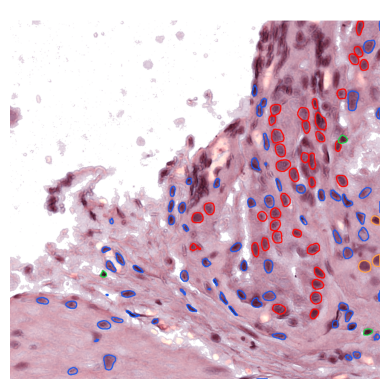

In [124]:
# Display the final image with overlaid nuclei
plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

#### Include the lables

In [188]:
# Load image
patch = cv2.imread(f"gall-bladder_patch_with_nuclei_colored_{row}_{col}.png")

In [189]:
# Load the geojson file
geojson_path = "gall-bladder_patch_segmentation_0_34.geojson"

with open(geojson_path, "r") as f:
    geojson_data = json.load(f)

In [190]:
# Extract features from FeatureCollection
if isinstance(geojson_data, dict) and geojson_data.get("type") == "FeatureCollection":
    features = geojson_data.get("features", [])
    print(f"Number of features: {len(features)}")
else:
    raise ValueError("GeoJSON data is not a FeatureCollection or is malformed")

Number of features: 4


In [191]:
# Extract unique cell types and their colors
cell_type_color_map = {}
for feature in features:
    if not isinstance(feature, dict):
        print(f"Skipping invalid feature: {feature}")
        continue

    geometry = feature.get("geometry", {})
    if geometry.get("type") == "MultiPolygon":

        try:
            properties = feature["properties"]
            classification = properties["classification"]
            cell_type = classification["name"]
            rgb_color = classification["color"]  
            bgr_color = (rgb_color[2], rgb_color[1], rgb_color[0]) 
            if cell_type not in cell_type_color_map:
                cell_type_color_map[cell_type] = bgr_color
                
        except (KeyError, IndexError) as e:
            print(f"Error processing feature: {e}")
            cell_type = "Unknown"
            bgr_color = (0, 0, 255)  
            if cell_type not in cell_type_color_map:
                cell_type_color_map[cell_type] = bgr_color

In [192]:
# Color map
print("Cell type color map:")
for cell_type, color in cell_type_color_map.items():
    print(f"Cell type: {cell_type}, Color (BGR): {color}")

Cell type color map:
Cell type: Neoplastic, Color (BGR): (0, 0, 255)
Cell type: Inflammatory, Color (BGR): (77, 221, 34)
Cell type: Connective, Color (BGR): (236, 92, 35)
Cell type: Epithelial, Color (BGR): (68, 159, 255)


In [193]:
# Legend in the top left corner
legend_x = 10
legend_y = 10
legend_width = 250
legend_height = 25 * len(cell_type_color_map) + 30
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_thickness = 2
text_color = (255, 255, 255)  
overlay = patch.copy()
alpha = 0.6
cv2.rectangle(
    overlay, 
    (legend_x, legend_y), 
    (legend_x + legend_width, legend_y + legend_height), 
    (50, 50, 50), 
    -1
)
cv2.addWeighted(overlay, alpha, patch, 1 - alpha, 0, patch)

for idx, (cell_type, color) in enumerate(cell_type_color_map.items()):
    square_x = legend_x + 10
    square_y = legend_y + 10 + idx * 30  # Increased vertical padding
    cv2.rectangle(patch, (square_x, square_y), (square_x + 15, square_y + 15), color, -1)
    
    text_x = square_x + 25
    text_y = square_y + 12
    cv2.putText(patch, cell_type, (text_x, text_y), font, font_scale, text_color, font_thickness)

In [194]:
# Save the image with the legend
output_path = f"gall-bladder_patch_with_nuclei_colored_with_legend_{row}_{col}.png"
cv2.imwrite(output_path, patch)
print(f"Image with legend saved as {output_path}")

Image with legend saved as gall-bladder_patch_with_nuclei_colored_with_legend_0_34.png
